In [9]:
# Import
import numpy as np
import torch
import scipy.io
from matplotlib import pyplot as plt
import time
import torcwa
import Materials

# Hardware
# If GPU support TF32 tensor core, the matmul operation is faster than FP32 but with less precision.
# If you need accurate operation, you have to disable the flag below.
torch.backends.cuda.matmul.allow_tf32 = False
sim_dtype = torch.complex64
geo_dtype = torch.float32
device = torch.device('cuda')

# Simulation environment
# light
lamb0 = torch.tensor(940.,dtype=geo_dtype,device=device)    # nm
inc_ang = 0.*(np.pi/180)    # radian
azi_ang = 0.*(np.pi/180)    # radian

# material
substrate_eps = 1.46**2
silicon_eps = Materials.aSiH.apply(lamb0)**2

# geometry
L = [7648.5*2 , 4041.]            # nm / nm
torcwa.rcwa_geo.dtype = geo_dtype
torcwa.rcwa_geo.device = device
torcwa.rcwa_geo.Lx = L[0]
torcwa.rcwa_geo.Ly = L[1]
torcwa.rcwa_geo.nx = int(L[0]//4)
torcwa.rcwa_geo.ny = int(L[1]//4)
torcwa.rcwa_geo.grid()
torcwa.rcwa_geo.edge_sharpness = 1000. #????

x_axis = torcwa.rcwa_geo.x.cpu()
y_axis = torcwa.rcwa_geo.y.cpu()
# layers
layer0_thickness = 235.

In [10]:
def hexagonal_sym(rho):
    height, width = rho.shape
    rho_left_top = rho[:height//2,:width//2]
    sub_height, sub_width = rho_left_top.shape
    # 創建布爾對角 (向量化操作)
    x, y = torch.meshgrid(torch.arange(sub_height, device=device), torch.arange(sub_width, device=device), indexing='ij')
    mask = y*sub_height/sub_width < x

    # 將掩膜應用於rho_left_up，將滿足條件的元素設置為0
    rho_left_top[mask] = 0
    rho_left_top = rho_left_top + torch.fliplr(torch.flipud(rho_left_top))

    rho_right_top = torch.fliplr(rho_left_top)

    # 拼接整個矩陣 (左右部分)
    rho_top = torch.concatenate((rho_left_top, rho_right_top), axis=1)

    rho_bottom = torch.flipud(rho_top)
    # 拼接整個矩陣 (上下部分)
    rho_hex = torch.concatenate((rho_top, rho_bottom), axis=0)
    return rho_hex

def get_order(sim,orders=[0,0],direction='forward',port='transmission',ref_order=[0,0]):
    '''
        Return T_all.

        Parameters
        - orders: selected orders (Recommended shape: Nx2)
        - direction: set the direction of light propagation ('f', 'forward' / 'b', 'backward')
        - port: set the direction of light propagation ('t', 'transmission' / 'r', 'reflection')
        - polarization: set the input and output polarization of light ((output,input) xy-pol: 'xx' / 'yx' / 'xy' / 'yy' , ps-pol: 'pp' / 'sp' / 'ps' / 'ss' )
        - ref_order: set the reference for calculating S-parameters (Recommended shape: Nx2)
        - power_norm: if set as True, the absolute square of S-parameters are corresponds to the ratio of power
        - evanescent: Criteria for judging the evanescent field. If power_norm=True and real(kz_norm)/imag(kz_norm) < evanscent, function returns 0 (default = 1e-3)

        Return
        - T_all (torch.Tensor)
    '''
    txx = sim.S_parameters(orders=orders,direction=direction,port=port,polarization='xx',ref_order=ref_order)
    tyy = sim.S_parameters(orders=orders,direction=direction,port=port,polarization='yy',ref_order=ref_order)
    txy = sim.S_parameters(orders=orders,direction=direction,port=port,polarization='xy',ref_order=ref_order)
    tyx = sim.S_parameters(orders=orders,direction=direction,port=port,polarization='yx',ref_order=ref_order)
    T_all = torch.abs(txx)**2 + torch.abs(tyy)**2 + torch.abs(txy)**2 + torch.abs(tyx)**2
    return T_all

# Objective function
def objective_function(rho):
    harmonic_order = [27,11]

    sim = torcwa.rcwa(freq=1/lamb0,order=harmonic_order,L=L,dtype=sim_dtype,device=device)
    sim.add_input_layer(eps=substrate_eps)
    sim.set_incident_angle(inc_ang=inc_ang,azi_ang=azi_ang)
    layer0_eps = rho*silicon_eps + (1.-rho)
    sim.add_layer(thickness=layer0_thickness,eps=layer0_eps)
    sim.solve_global_smatrix()
    T_hex1 = [get_order(sim,orders=[xorder,yorder],direction='forward',port='transmission',ref_order=[0,0]) for xorder in range(-12,13,2) for yorder in range(-2,3,2)]
    T_hex2 = [get_order(sim,orders=[xorder,yorder],direction='forward',port='transmission',ref_order=[0,0]) for xorder in range(-11,12,2) for yorder in range(-3,4,2)]
    T_hex = torch.cat([*T_hex1, *T_hex2])
    # Calculate the minimum and maximum of the concatenated tensor
    min_T = torch.min(T_hex)
    max_T = torch.max(T_hex)
    #efficiency = torch.sum(T_hex)
    # Compute the uniformity value
    uniformity = (min_T / max_T)

    #FoM = efficiency + uniformity
    return uniformity

initial = 0.07319140434265137


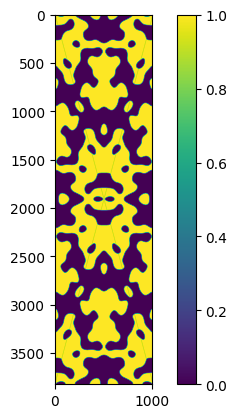

Iteration: 0 / FoM: 0.014103710651397705 / Elapsed time: 24 s


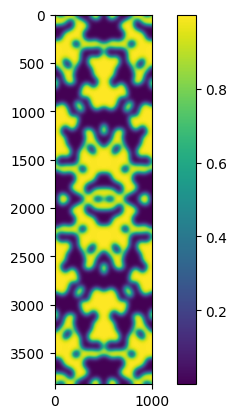

Iteration: 50 / FoM: 0.05081972852349281 / Elapsed time: 1191 s


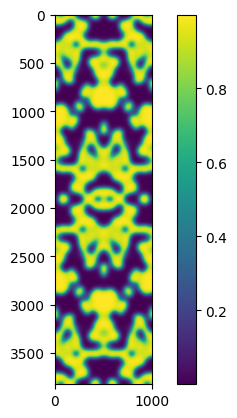

Iteration: 100 / FoM: 0.17027106881141663 / Elapsed time: 2356 s


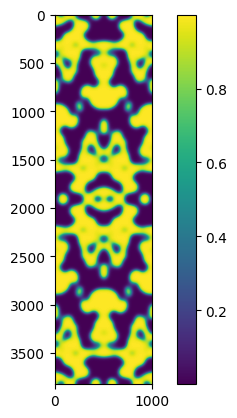

Iteration: 150 / FoM: 0.35778045654296875 / Elapsed time: 3511 s


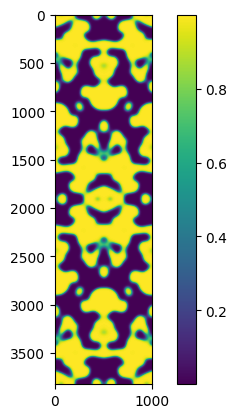

Iteration: 200 / FoM: 0.5266798138618469 / Elapsed time: 4662 s


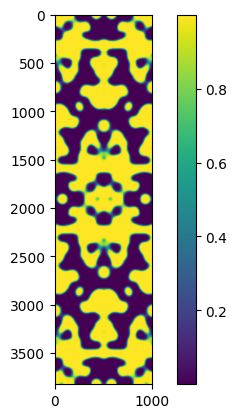

Iteration: 250 / FoM: 0.6485346555709839 / Elapsed time: 5808 s


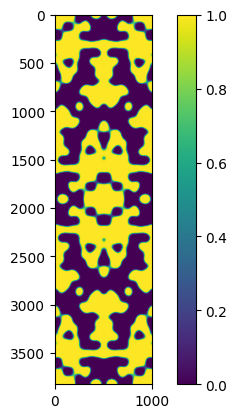

Iteration: 300 / FoM: 0.584166407585144 / Elapsed time: 6948 s


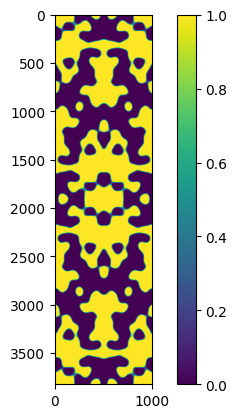

Iteration: 350 / FoM: 0.7320600748062134 / Elapsed time: 8089 s


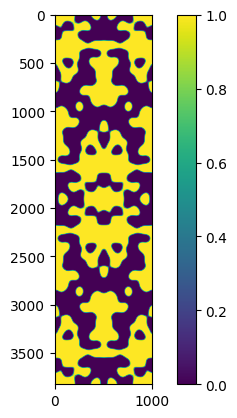

Iteration: 400 / FoM: 0.7859824895858765 / Elapsed time: 9226 s


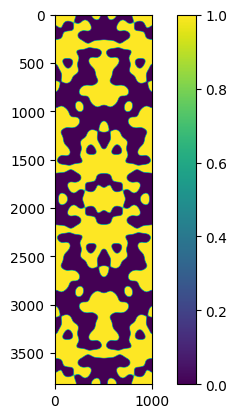

Iteration: 450 / FoM: 0.8197038173675537 / Elapsed time: 10361 s


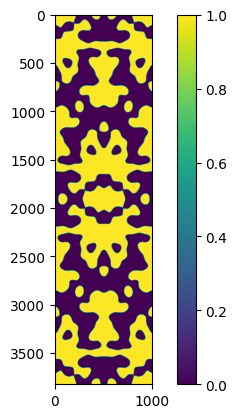

Iteration: 500 / FoM: 0.8789767026901245 / Elapsed time: 11498 s


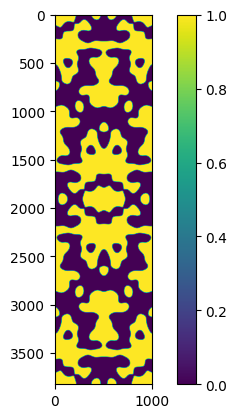

Iteration: 550 / FoM: 0.9421684741973877 / Elapsed time: 12637 s


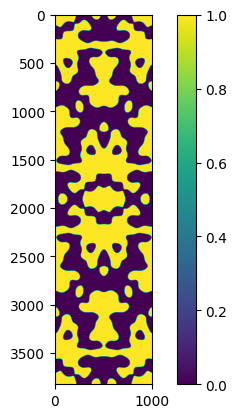

Iteration: 600 / FoM: 0.897794783115387 / Elapsed time: 13775 s


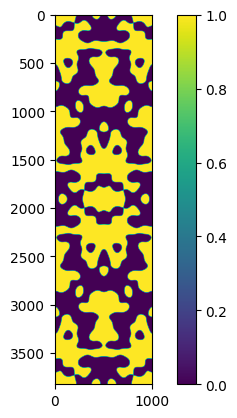

Iteration: 650 / FoM: 0.9605796933174133 / Elapsed time: 14913 s


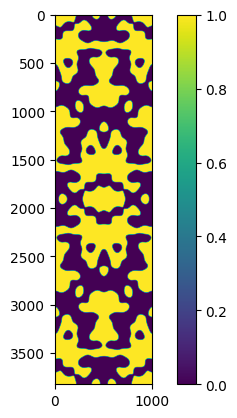

Iteration: 700 / FoM: 0.974642813205719 / Elapsed time: 16052 s


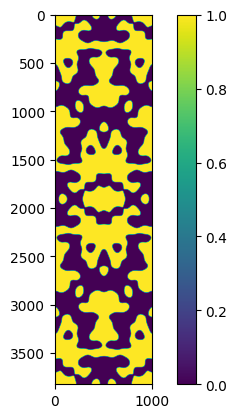

Iteration: 750 / FoM: 0.9884861707687378 / Elapsed time: 17191 s


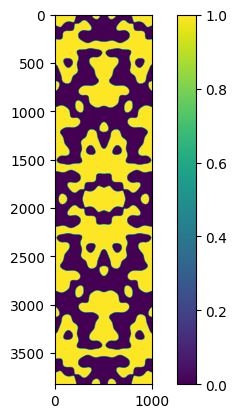

In [22]:
# Perform optimization
# optimizer parameters for ADAM optimizer
gar_initial = 0.03
beta1 = 0.9
beta2 = 0.999
epsilon = 1.e-8
iter_max = 800
beta = np.exp(np.arange(start=0,stop=iter_max)*np.log(1000)/iter_max)
beta = torch.from_numpy(beta)
gar = gar_initial * 0.5*(1+np.cos(np.arange(start=0,stop=iter_max)*np.pi/iter_max))
# blur kernel
blur_radius = 150.
dx, dy = L[0]/torcwa.rcwa_geo.nx, L[1]/torcwa.rcwa_geo.ny
x_kernel_axis = (torch.arange(torcwa.rcwa_geo.nx,dtype=geo_dtype,device=device)-(torcwa.rcwa_geo.nx-1)/2)*dx
y_kernel_axis = (torch.arange(torcwa.rcwa_geo.ny,dtype=geo_dtype,device=device)-(torcwa.rcwa_geo.ny-1)/2)*dy
x_kernel_grid, y_kernel_grid = torch.meshgrid(x_kernel_axis,y_kernel_axis,indexing='ij')
g = torch.exp(-(x_kernel_grid**2+y_kernel_grid**2)/blur_radius**2)
g = g/torch.sum(g)
g_fft = torch.fft.fftshift(torch.fft.fft2(torch.fft.ifftshift(g)))
torch.manual_seed(333)
import cv2
image_path = 'check_point_hex.png'
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
image_resized = cv2.resize(image, (torcwa.rcwa_geo.ny, torcwa.rcwa_geo.nx))/ 255.0 
# Convert image to tensor
rho = torch.tensor(image_resized, dtype=geo_dtype, device=device)
rho = hexagonal_sym(rho)
print(f'initial = {objective_function(rho)}')
plt.imshow(rho.cpu().numpy())
plt.colorbar()
plt.show()
momentum = torch.zeros_like(rho)
velocity = torch.zeros_like(rho)
rho_history = []
FoM_history = []

start_time = time.time()
for it in range(0,iter_max):
    rho.requires_grad_(True)
    rho_fft = torch.fft.fftshift(torch.fft.fft2(torch.fft.ifftshift(rho)))
    rho_bar = torch.real(torch.fft.fftshift(torch.fft.ifft2(torch.fft.ifftshift(rho_fft*g_fft))))
    rho_tilda = 1/2 + torch.tanh(2*beta[it]*rho_bar-beta[it])/(2*torch.tanh(beta[it]))
    FoM = objective_function(rho_tilda)
    FoM.backward()

    with torch.no_grad():
        rho_gradient = rho.grad
        rho.grad = None

        FoM = float(FoM.detach().cpu().numpy())
        FoM_history.append(FoM)

        momentum = (beta1*momentum + (1-beta1)*rho_gradient)
        velocity = (beta2*velocity + (1-beta2)*(rho_gradient**2))

        momentum_hat = (momentum / (1-beta1**(it+1)))
        velocity_hat = (velocity / (1-beta2**(it+1)))

        rho += gar[it]* momentum_hat/ (torch.sqrt(velocity_hat) + epsilon)
        #rho_tilda = 1/2 + torch.tanh(2*beta[it]*rho_bar-beta[it])/(2*torch.tanh(beta[it]))
        rho[rho>1] = 1
        rho[rho<0] = 0
        rho = hexagonal_sym(rho)
        if it%50 == 0:
            rho_history.append(rho_tilda.detach().cpu().numpy())
            end_time = time.time()
            elapsed_time = end_time - start_time
            print('Iteration:',it,'/ FoM:',FoM,'/ Elapsed time:',str(int(elapsed_time))+' s')
            plt.imshow(rho_tilda.detach().cpu().numpy())
            plt.colorbar()
            plt.show()
            #print(rho2.cpu().numpy())

0.99220324


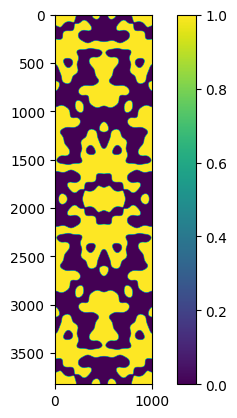

In [23]:
plt.plot(np.array(FoM_history))
# Export data
filename = 'DOE_hex_data2.mat'
ex6_data = {'rho_history':rho_history,'FoM_history':FoM_history}
scipy.io.savemat(filename,ex6_data)
rho2 = rho_tilda.detach()
#rho2[rho2>0.5] = 1
#rho2[rho2<0.5] = 0
print(objective_function(rho2).cpu().numpy())
# Plot
plt.imshow(rho2.cpu().numpy())
plt.colorbar()

In [5]:
# Objective function
def val_function(rho):
    harmonic_order = [27,11]
    sim = torcwa.rcwa(freq=1/lamb0,order=harmonic_order,L=L,dtype=sim_dtype,device=device)
    sim.add_input_layer(eps=substrate_eps)
    sim.set_incident_angle(inc_ang=inc_ang,azi_ang=azi_ang)
    layer0_eps = rho*silicon_eps + (1.-rho)
    sim.add_layer(thickness=layer0_thickness,eps=layer0_eps)
    sim.solve_global_smatrix()
    T_hex1 = [get_order(sim,orders=[xorder,yorder],direction='forward',port='transmission',ref_order=[0,0]) for xorder in range(-12,13,2) for yorder in range(-2,3,2)]
    T_hex2 = [get_order(sim,orders=[xorder,yorder],direction='forward',port='transmission',ref_order=[0,0]) for xorder in range(-11,12,2) for yorder in range(-3,4,2)]
    T_hex = torch.cat([*T_hex1, *T_hex2])

    T_rect1 = [get_order(sim,orders=[xorder,yorder],direction='forward',port='transmission',ref_order=[0,0]) for xorder in range(-11,12,2) for yorder in range(-2,3,2)]
    T_rect2 = [get_order(sim,orders=[xorder,yorder],direction='forward',port='transmission',ref_order=[0,0]) for xorder in range(-12,13,2) for yorder in range(-3,4,2)]
    T_rect = torch.cat([*T_rect1, *T_rect2])
    
    return T_hex, T_rect
""" image_path = 'check_point.png'
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
image_resized = cv2.resize(image, (torcwa.rcwa_geo.ny, torcwa.rcwa_geo.nx))/ 255.0 
# Convert image to tensor
rho = torch.tensor(image_resized, dtype=geo_dtype, device=device)
rho = hexagonal_sym(rho)
 """
print(f'initial = {objective_function(rho_tilda)}')
plt.imshow(rho_tilda.detach().cpu().numpy())
plt.colorbar()
plt.show()
T_hex, T_rect = val_function(rho_tilda)

print(f'hexagonal order efficiency : {T_hex}')
print(f'rectangle order efficiency : {T_rect}')
cv2.imwrite('check_point_hex2.png',rho_tilda.detach().cpu().numpy()*255)

NameError: name 'objective_function' is not defined

===> Avg. efficiency: 74.33 %
===> Avg. uniformity: 47.18 %
(73,)


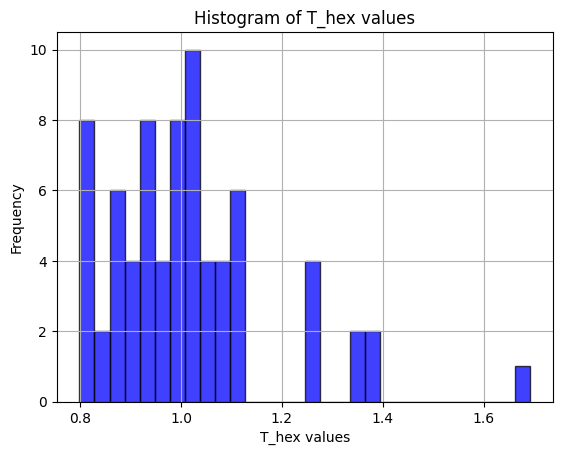

In [22]:
import cv2
image_path = 'check_point_hex2.png'
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
image_resized = cv2.resize(image, (torcwa.rcwa_geo.ny, torcwa.rcwa_geo.nx))/ 255.0 
# Convert image to tensor
rho = torch.tensor(image_resized, dtype=geo_dtype, device=device)
# order
lamb0 = torch.tensor(940.,dtype=geo_dtype,device=device)    # nm
n = np.arange(-100//2, 100//2 +1)
m = np.arange(-100//2, 100//2 +1)
yorder, xorder = np.meshgrid(m, n)
kx = xorder * lamb0.cpu().numpy()/L[1]
ky = yorder * lamb0.cpu().numpy()/L[0]
exist_xorder = xorder[np.where((kx**2 + ky**2) <= 1)]
exist_yorder = yorder[np.where((kx**2 + ky**2) <= 1)]
def validate(rho):
    harmonic_order = [25, 11]

    sim = torcwa.rcwa(freq=1/lamb0,order=harmonic_order,L=L,dtype=sim_dtype,device=device)
    sim.add_input_layer(eps=substrate_eps)
    sim.set_incident_angle(inc_ang=inc_ang,azi_ang=azi_ang)
    layer0_eps = rho*silicon_eps + (1.-rho)
    sim.add_layer(thickness=layer0_thickness,eps=layer0_eps)
    sim.solve_global_smatrix()

    T_hex1 = [get_order(sim,orders=[xorder,yorder],direction='forward',port='transmission',ref_order=[0,0]) for xorder in range(-12,13,2) for yorder in range(-2,3,2)]
    T_hex2 = [get_order(sim,orders=[xorder,yorder],direction='forward',port='transmission',ref_order=[0,0]) for xorder in range(-11,12,2) for yorder in range(-3,4,2)]
    T_hex = torch.cat([*T_hex1, *T_hex2])

    T_all = [get_order(sim,orders=[xorder,yorder],direction='forward',port='transmission',ref_order=[0,0]) for xorder, yorder in zip(exist_yorder, exist_xorder)]
    T_all = torch.cat(T_all)
    # Calculate the minimum and maximum of the concatenated tensor
    min_T = torch.min(T_hex)
    max_T = torch.max(T_hex)
    efficiency = torch.sum(T_hex) / torch.sum(T_all)
    # Compute the uniformity value
    uniformity = min_T / max_T
    print("===> Avg. efficiency: {:.2f} %".format(efficiency*100))
    print("===> Avg. uniformity: {:.2f} %".format(uniformity*100))
    T_hex_np = T_hex.detach().cpu().numpy()
    print(T_hex_np.shape)
    # 画直方图
    plt.hist(T_hex_np*100, bins=30, alpha=0.75, color='blue', edgecolor='black')
    plt.xlabel('T_hex values')
    plt.ylabel('Frequency')
    plt.title('Histogram of T_hex values')
    plt.grid(True)
    plt.show()
validate(rho)